# Online Retail Customer Segmentation: K-Means Clustering & A/B Testing

This project aims to study customer behaviours on digital platforms by grouping customers without any prior knowledge and conduct A/B Testing that helps boost business performance.

<i>N.Avgeros (March 2022)</i>

---

## Context
I have been working in Advertising, specifically Digital Media and Performance, for nearly 3 years and customer behaviour analysis is one of the core concentrations in my day-to-day job. With the help of different analytics platforms (e.g. Google Analytics, Adobe Analytics), my life has been made easier than before since these platforms come with the built-in function of segmentation that analyses user behaviours across dimensions and metrics.

However, despite the convenience provided, I was hoping to leverage Machine Learning to do customer segmentation that can be scalable and applicable to other optimizations in Data Science (e.g. A/B Testing). Then, I came across the dataset provided by Google Analytics for a Kaggle competition and decided to use it for this project.

Feel free to check out the dataset here if you’re keen! Beware that the dataset has several sub-datasets and each has more than 900k rows!

---

## A. Explanatory Data Analysis (EDA)

<i>This always remain an essential step in every Data Science project to ensure the dataset is clean and properly pre-processed to be used for modelling.</i>

First of all, let’s import all the necessary libraries and read the csv file:

## 1. Explanatory Data Analysis (EDA)

Customer Segmentation: K-Means Clustering & A/B Testing
This project aims to study customer behaviours on digital platforms by grouping customers without any prior knowledge and conduct A/B Testing that helps boost business performance.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from itertools import chain, cycle
from datetime import datetime, timedelta
import pycountry_convert as pc
from IPython.display import display, display_html
from yellowbrick.cluster import KElbowVisualizer
import seaborn as sns
sns.set(style="darkgrid")
import warnings
warnings.filterwarnings("ignore")

# Scikit learn
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
%%HTML
<style>.dataframe th{
background:#3f577c; 
font-family:monospace;
padding: 5px;
color:white;
border:1px solid white; 
text-align:center !important;}
</style>

In [3]:
data_df = pd.read_csv("data.csv", encoding="ANSI")
data_df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,12/1/2010 8:26,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,12/1/2010 8:26,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,12/1/2010 8:28,1.85,17850.0,United Kingdom
9,536367,84879,ASSORTED COLOUR BIRD ORNAMENT,32,12/1/2010 8:34,1.69,13047.0,United Kingdom


In [4]:
# Dataset overview
def df_overview(df):
    
    """ 
    Overview of missing data, dimension & duplicates in a dataframe 
    
    Inputs
    ------
        Dataframe
    
    Returns
    -------
        Dataframe using the display function from IPython.display package order by Total in descending order
        
    """
    
    overview_df = pd.DataFrame({"Total":df.isna().sum()})
    overview_df["% Missing"] = round((overview_df["Total"] / len(df)) * 100, 1)
    overview_df["Type"] = df.dtypes
    duplicates_df = df[df.duplicated()]
    print("Dimensions: {}\nDuplicates: {}".format(df.shape, len(duplicates_df)))
    return display(overview_df.sort_values(by="Total", ascending=False))


# Compare Dataframes
def df_compare(*args, titles=cycle([''])):
    
    """ 
    Display dataframes side by side 
    
    Inputs
    ------
        *args: pandas dataframes
        titles: titles of each dataframe
    
    Returns
    -------
        pandas dataframes displayed side by side by using the display_html() function from IPython.display package

    """
    
    html_str=''
    
    for df,title in zip(args, chain(titles,cycle(['</br>']))):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
        
    display_html(html_str,raw=True)

In [5]:
df_overview(data_df)

Dimensions: (541909, 8)
Duplicates: 5268


,Total,% Missing,Type
CustomerID,135080,24.9,float64
Description,1454,0.3,object
InvoiceNo,0,0.0,object
StockCode,0,0.0,object
Quantity,0,0.0,int64
InvoiceDate,0,0.0,object
UnitPrice,0,0.0,float64
Country,0,0.0,object


## 2. Data cleaning

<ol>
    <li>Change InvoiceDate type to datatime</li>
    <li>Handle duplicates</li>
    <li>Handle missing values</li>
</ol>

In [6]:
# Creating a new dataframe as checkpoint
clean_df = data_df.copy()

# Change to datatime type
clean_df["InvoiceDate"] = pd.to_datetime(clean_df["InvoiceDate"])
clean_df.dropna(axis=0, subset=['CustomerID'], inplace=True)
clean_df.drop_duplicates(inplace=True)
df_overview(clean_df)

Dimensions: (401604, 8)
Duplicates: 0


,Total,% Missing,Type
InvoiceNo,0,0.0,object
StockCode,0,0.0,object
Description,0,0.0,object
Quantity,0,0.0,int64
InvoiceDate,0,0.0,datetime64[ns]
UnitPrice,0,0.0,float64
CustomerID,0,0.0,float64
Country,0,0.0,object


## Data exploration

This dataframe contains 8 variables that correspond to:


#### InvoiceNo:
Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
#### StockCode:
Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
#### Description:
Product (item) name. Nominal.
#### Quantity:
The quantities of each product (item) per transaction. Numeric.
#### InvoiceDate:
Invice Date and time. Numeric, the day and time when each transaction was generated.
#### UnitPrice:
Unit price. Numeric, Product price per unit in sterling.
#### CustomerID:
Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
#### Country:
Country name. Nominal, the name of the country where each customer resides.

## 2.1 Analysis

Let's make a copy of the cleaned dataset as we are going to create new calculated columns.

In [7]:
# Continent
def get_continent(country):
    """ Finds the continent from a given country """
    if country in ['EIRE', 'European Community', "Channel Islands"]:
        return 'Europe'
    elif country == 'RSA':
        return 'Africa'
    elif country == "Unspecified":
        return country
    else:  
        continents = {
                'NA': 'North America',
                'SA': 'South America', 
                'AS': 'Asia',
                'OC': 'Australia',
                'AF': 'Africa',
                'EU': 'Europe',
            }
    return continents[pc.country_alpha2_to_continent_code(pc.country_name_to_country_alpha2(country))] 

In [8]:
analysis_df = clean_df.copy()
analysis_df["Continent"] = analysis_df["Country"].map(get_continent)
analysis_df["Cancelled"] = (analysis_df["InvoiceNo"].str.contains('C')>0).astype(int)
analysis_df["Recency"] = (max(analysis_df['InvoiceDate']) - analysis_df['InvoiceDate']).dt.days
analysis_df["Amount"] = analysis_df["Quantity"] * analysis_df["UnitPrice"]
display(analysis_df.head())

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Cancelled,Recency,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,Europe,0,373,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,0,373,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,Europe,0,373,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,0,373,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,Europe,0,373,20.34


### Peculiar transactions 

<ul>
    <li>POST -> POSTAGE</li>                    
    <li>D -> Discount</li>                   
    <li>C2 -> CARRIAGE</li>                   
    <li>M -> Manual</li>                   
    <li>BANK CHARGES -> Bank Charges</li>               
    <li>PADS -> PADS TO MATCH ALL CUSHIONS</li> 
    <li>DOT -> DOTCOM POSTAGE</li> 
<ul>

In [9]:
special_codes_df = analysis_df[analysis_df.StockCode.str.contains('^[a-zA-Z]')]
display(special_codes_df)
special_codes_lst = special_codes_df.StockCode.unique().tolist()
print("Special stock codes: {}".format(', '.join(special_codes_lst)))

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Continent,Cancelled,Recency,Amount
45,536370,POST,POSTAGE,3,2010-12-01 08:45:00,18.00,12583.0,France,Europe,0,373,54.00
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom,Europe,1,373,-27.50
386,536403,POST,POSTAGE,1,2010-12-01 11:27:00,15.00,12791.0,Netherlands,Europe,0,373,15.00
1123,536527,POST,POSTAGE,1,2010-12-01 13:04:00,18.00,12662.0,Germany,Europe,0,372,18.00
1423,536540,C2,CARRIAGE,1,2010-12-01 14:05:00,50.00,14911.0,EIRE,Europe,0,372,50.00
...,...,...,...,...,...,...,...,...,...,...,...,...
541216,581494,POST,POSTAGE,2,2011-12-09 10:13:00,18.00,12518.0,Germany,Europe,0,0,36.00
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom,Europe,1,0,-224.69
541730,581570,POST,POSTAGE,1,2011-12-09 11:59:00,18.00,12662.0,Germany,Europe,0,0,18.00
541767,581574,POST,POSTAGE,2,2011-12-09 12:09:00,18.00,12526.0,Germany,Europe,0,0,36.00


Special stock codes: POST, D, C2, M, BANK CHARGES, PADS, DOT, CRUK



### Top 15 customers by Quantity, Amount, Products, Transactions, Cancellations

In [55]:
# Transactions by customer
transactions_dict = dict()
for customer, group in analysis_df.groupby(["CustomerID"]):
    if not transactions_dict.get(customer, 0): 
        transactions_dict[customer] = group["InvoiceDate"].tolist()
    else:
        transactions_dict[customer].append(group["InvoiceDate"].tolist())   
transactions_dict = {key: Counter(value) for key, value in transactions_dict.items()}

# Create customers' profile
customers_details_df = analysis_df.groupby(['CustomerID']).agg({
    'Quantity' : 'sum',
    'InvoiceNo': 'count',
    'UnitPrice' : 'sum',
    'Cancelled' : 'sum',
    'Amount': 'sum',
    'Recency' : 'min'
}).join( # Transactions per customer
    pd.DataFrame({key:[len(value)] for key, value in transactions_dict.items()},
                 index=["Transactions"]).T
 ).join( # Last Transaction per customer
    pd.DataFrame({key: list(transactions_dict[key].keys())[-1] for key in transactions_dict.keys()},
                 index=['LastTransaction']).T
).join( # Country & Continent 
    analysis_df.drop_duplicates(subset='CustomerID', keep='first').set_index('CustomerID')[["Country", 'Continent']]
).join( # Products bought per customer excluding special charges (POST, D, C2, M, BANK CHARGES, PADS, DOT, CRUK)
    analysis_df[~(analysis_df['StockCode'].isin(special_codes_lst))].groupby(
        'CustomerID').count()[['InvoiceNo']].rename(columns={'InvoiceNo':'Products'})
).rename(columns={'Transactions':'Frequency',
                 'Amount': 'Monetary'}) # Rename Invoice Number to Frequency

# Reorder columns
customers_details_df = customers_details_df.reindex(columns=['Quantity', 'UnitPrice', 'Monetary', 'Country',
                                                             'Continent', 'Frequency', 'Products','Cancelled',
                                                             'LastTransaction', 'Recency'])
# May exists NaN in Products 
customers_details_df.fillna(0, inplace=True)
# Change Products type from float to integer
customers_details_df['Products'] = customers_details_df['Products'].astype(int)

# Order by function
def df_ordering(df, order_by, ascending=False, records_num=15):
    """Returns N highest or lowest record from a dataframe"""
    return df.sort_values(by=order_by, ascending=ascending).head(records_num)

df_compare(df_ordering(customers_details_df[['Recency']], 'Recency', ascending=True),
                   df_ordering(customers_details_df[['Monetary']], 'Monetary'),
                   df_ordering(customers_details_df[['Frequency']], 'Frequency'),
                   df_ordering(customers_details_df[['Products']], 'Products'),
                   df_ordering(customers_details_df[['Cancelled']], 'Cancelled'))

,Recency
CustomerID,
17491.0,0
16933.0,0
16558.0,0
13026.0,0
17364.0,0
14702.0,0
13013.0,0
15344.0,0
12518.0,0


### Overview a customer's profile and activity

In [56]:
def customer_overview(customer_id, details=None):
    """ Returns customer's profile and transactions """
    
    transactions_df = analysis_df[analysis_df["CustomerID"]==customer_id].drop(columns=['CustomerID', 'Country', 'Continent'])
    profile_df = pd.DataFrame(customers_details_df.loc[customer_id, :])
    return df_compare(profile_df, transactions_df, titles=["Profile", "Details"])

In [57]:
customer_overview(12665.0)

,12665.0
Quantity,36
UnitPrice,21.75
Monetary,61.75
Country,Germany
Continent,Europe
Frequency,2
Products,3
Cancelled,1
LastTransaction,2011-01-19 08:34:00
Recency,324


### Cancelled invoices

In [58]:
df_compare(pd.DataFrame(analysis_df["Cancelled"].value_counts()),
           pd.DataFrame(analysis_df["Cancelled"].value_counts(normalize=True)*100),
           titles=["Total", "Percentage"])

,Cancelled
0,392732
1,8872
,Cancelled
0,97.790859
1,2.209141


### Countries and continents were the most orders made

In [59]:
# Country
country_df = pd.DataFrame({"Orders":analysis_df["Country"].value_counts(),
              "% Orders": round((analysis_df["Country"].value_counts(normalize=True)*100), 4)})

# Continent
continent_df = pd.DataFrame({"Orders":analysis_df["Continent"].value_counts(),
              "% Orders": round((analysis_df["Continent"].value_counts(normalize=True)*100), 4)})

# Country & Continent
df_compare(country_df.head(15), continent_df, titles=['By Country (Top 15)','By Continent'])

,Orders,% Orders
United Kingdom,356728,88.8258
Germany,9480,2.3605
France,8475,2.1103
EIRE,7475,1.8613
Spain,2528,0.6295
Netherlands,2371,0.5904
Belgium,2069,0.5152
Switzerland,1877,0.4674
Portugal,1471,0.3663
Australia,1258,0.3132


### Monthly Revenue

,Amount
InvoiceDate,
2010-12-31,552372.860
2011-01-31,473731.900
2011-02-28,435534.070
2011-03-31,578576.210
2011-04-30,425222.671
2011-05-31,647011.670
2011-06-30,606862.520
2011-07-31,573112.321
2011-08-31,615078.090


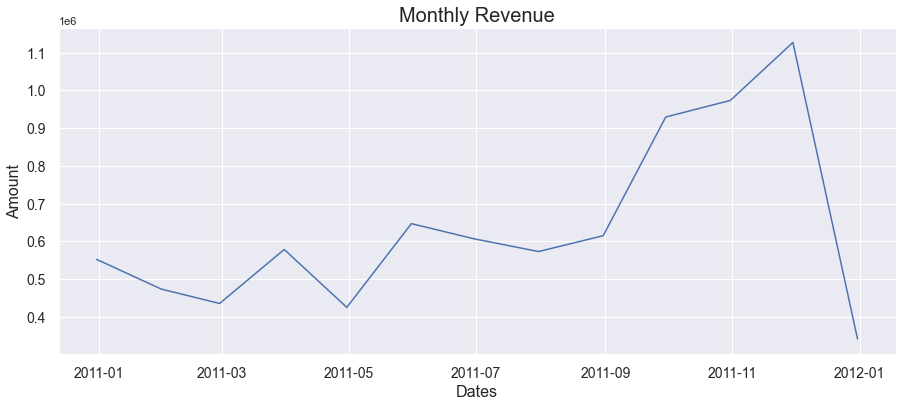

In [60]:
monthly_revenue_df = (analysis_df.groupby(["InvoiceDate"]).sum()[["Amount"]]).resample('M').sum()

# InvoiceDate & Amount
df_compare(df_ordering(monthly_revenue_df, "InvoiceDate", ascending=True, records_num=len(monthly_revenue_df)), 
           df_ordering(monthly_revenue_df, "InvoiceDate", ascending=False, records_num=len(monthly_revenue_df)), 
           df_ordering(monthly_revenue_df, "Amount", ascending=True, records_num=len(monthly_revenue_df)),
           df_ordering(monthly_revenue_df, "Amount", ascending=False, records_num=len(monthly_revenue_df)),
           titles=['InvoiceDate ASC','InvoiceDate DESC', "Amount ASC", "Amount DESC"])

# Plot Monthly Revenue
plt.figure(figsize=(15,6))
sns.lineplot(x='InvoiceDate', y='Amount', data=monthly_revenue_df)
plt.figsize=(16,6)
plt.title('Monthly Revenue', fontsize=20)
plt.xlabel('Dates', fontsize=16);
plt.ylabel('Amount', fontsize=16);
plt.tick_params(axis='both', which='major', labelsize=14)
plt.show()

## Data Preprocessing

We preprocess the dataset so that it can be inputted into the clustering algorithm. This entails:
<ol>
    <li>removing unwanted features</li>
    <li>removing outliers</li>
    <li>encoding categorical features</li>
</ol>

### 1. Removing unwanted features

We can simply recreate a new dataframe as a checkpoint and then we drop the columns that we do not want to include in our model. More specifically, we will keep the Amount, Products, and Recency columns.

In [64]:
customers_details_df

,Quantity,UnitPrice,Monetary,Country,Continent,Frequency,Products,Cancelled,LastTransaction,Recency
CustomerID,,,,,,,,,,
12346.0,0,2.08,0.00,United Kingdom,Europe,2,2,1,2011-01-18 10:17:00,325
12347.0,2458,481.21,4310.00,Iceland,Europe,7,182,0,2011-12-07 15:52:00,1
12348.0,2341,178.71,1797.24,Finland,Europe,4,27,0,2011-09-25 13:13:00,74
12349.0,631,605.10,1757.55,Italy,Europe,1,72,0,2011-11-21 09:51:00,18
12350.0,197,65.30,334.40,Norway,Europe,1,16,0,2011-02-02 16:01:00,309
...,...,...,...,...,...,...,...,...,...,...
18280.0,45,47.65,180.60,United Kingdom,Europe,1,10,0,2011-03-07 09:52:00,277
18281.0,54,39.36,80.82,United Kingdom,Europe,1,7,0,2011-06-12 10:53:00,180
18282.0,98,62.68,176.60,United Kingdom,Europe,3,13,1,2011-12-02 11:43:00,7


In [65]:
preprocess_df = customers_details_df.copy()[['Monetary', 'Frequency', 'Recency', 'Continent', 'Cancelled']]
preprocess_df

,Monetary,Frequency,Recency,Continent,Cancelled
CustomerID,,,,,
12346.0,0.00,2,325,Europe,1
12347.0,4310.00,7,1,Europe,0
12348.0,1797.24,4,74,Europe,0
12349.0,1757.55,1,18,Europe,0
12350.0,334.40,1,309,Europe,0
...,...,...,...,...,...
18280.0,180.60,1,277,Europe,0
18281.0,80.82,1,180,Europe,0
18282.0,176.60,3,7,Europe,1


### 2. Encoding Categorical Features
<strong>Label Encoding</strong> refers to converting the labels into a numeric form so as to convert them into the machine-readable form. Machine learning algorithms can then decide in a better way how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.

As you can see in our dataframe, only the <mark>Continent column is the categorical feature</mark> as it is represented by the object data type and the rest of them are numerical features. We will use the LabelEncoder class from sklearn library to implement label encoding in our dataframe.

In [66]:
# Label Encoding
label_encoder = LabelEncoder()

# Create a list containing the categorical features
categorical_features_lst = preprocess_df.select_dtypes(include=object).columns.tolist()

for column in categorical_features_lst:
    # Label encoding implementation
    preprocess_df[column] = label_encoder.fit_transform(preprocess_df[column])
    
preprocess_df

,Monetary,Frequency,Recency,Continent,Cancelled
CustomerID,,,,,
12346.0,0.00,2,325,3,1
12347.0,4310.00,7,1,3,0
12348.0,1797.24,4,74,3,0
12349.0,1757.55,1,18,3,0
12350.0,334.40,1,309,3,0
...,...,...,...,...,...
18280.0,180.60,1,277,3,0
18281.0,80.82,1,180,3,0
18282.0,176.60,3,7,3,1


We can see that the <mark>Continent column contains only numerical values</mark>, which every value corresponds to a specific Continent. More specifically, Europe appears as 3 in our dataframe.

### 3. Outliers

The next step is to find and remove the outliers

In [85]:
from scipy import stats
print('Before: {}'.format(len(preprocess_df)))

# calculate z_scores 
scores_df = preprocess_df.apply(stats.zscore).apply(np.abs)

# Find outliers
outliers_df = scores_df[(scores_df['Monetary']>3) | (scores_df['Frequency']>3) | (scores_df['Recency']>3) | (scores_df['Cancelled']>3)]
preprocess_df = preprocess_df[~preprocess_df.index.isin(outliers_df.index)]

print('After: {}'.format(len(preprocess_df)))
print('Total Z-Scores: {}'.format(len(scores_df)))
print('Outliers found: {}'.format(len(outliers_df)))

preprocess_df

Before: 4115
After: 3851
Total Z-Scores: 4115
Outliers found: 264


,Monetary,Frequency,Recency,Continent,Cancelled,Cluster
CustomerID,,,,,,
12346.0,0.00,2,325,3,1,3
12347.0,4310.00,7,1,3,0,4
12348.0,1797.24,4,74,3,0,0
12349.0,1757.55,1,18,3,0,0
12350.0,334.40,1,309,3,0,3
...,...,...,...,...,...,...
18278.0,173.90,1,73,3,0,3
18280.0,180.60,1,277,3,0,3
18281.0,80.82,1,180,3,0,3


After the preprocessing, the data will undergo normalization and a principal component analysis (PCA). Normalizing the data ensures that the machine learning model is not biased towards any of the features, whereas a PCA will reduce the dimensionality of the dataset to mitigate overfitting.

In [86]:
# # Create a checkpoint a our data
# scaled_df = preprocess_df.copy()

# # MinMaxScaler Implementation
# min_max_scaler = MinMaxScaler([0, 1])
# scaled_df = pd.DataFrame(min_max_scaler.fit_transform(preprocess_df), columns=preprocess_df.columns, index=preprocess_df.index)

# # Scaled vs non Scaled
# df_compare(preprocess_df.head(10), scaled_df.head(10), titles=['Before MinMaxScaler', 'After MinMaxScaler'])

## Principal Component Analysis (PCA)

In [87]:
# Reduce dimensionality with PCA
n_components = 2
pca = PCA(n_components)
pca_df = pd.DataFrame(pca.fit_transform(preprocess_df), columns=['Component_'+str(i+1) for i in range(n_components)], index=preprocess_df.index)
display(pca_df.head(10))

print('Number of features before PCA: {}'.format(preprocess_df.shape[1]))
print('Number of features after PCA: {}'.format(pca_df.shape[1]))

,Component_1,Component_2
CustomerID,,
12346.0,-874.308755,189.629095
12347.0,3445.348416,42.588887
12348.0,931.709867,12.512184
12349.0,894.342367,-45.055033
12350.0,-539.537370,187.356868
12353.0,-780.385726,71.386313
12354.0,208.032846,139.962776
12355.0,-410.707806,96.563525
12356.0,1947.174357,2.140507


Number of features before PCA: 6
Number of features after PCA: 2


## Building The Clustering Model: KMeans

<strong>Kmeans clustering</strong> is one of the most popular clustering algorithms and usually the first thing practitioners apply when solving clustering tasks to get an idea of the structure of the dataset. The goal of kmeans is to group data points into distinct non-overlapping subgroups.


#### KMeans algorithm

<ol>
    <li>Choose the number K of clusters</li>
    <li>Select at random K points, the centroids (not necessarily from the dataset</li>
    <li>Assign each data point to the closest centroid -> That forms K clusters</li>
    <li>Compute and place the new centroid of each cluster</li>
    <li>Reassgin each data point to the new closest centroid. If any reassignment took place step 4 is repeated, otherwise the model is ready.</li>
</ol>

<div class="alert alert-block alert-success">
<b>Tip:</b> In order to avoid the Random Initialization Trap you can simply add the appropriate parameter in KMean class. By default, the KMeans class uses the 'k-means++' in "init" parameter.
</div>

In order to determine the ideal number of clusters for this batch of consumers we will use the elbow method.
While the elbow method can be performed manually, it is made a lot simpler with the yellowbrick library, which can build the visual plot with a single line of code.

###### Using the Elbow method to find the otpimal number of clusters

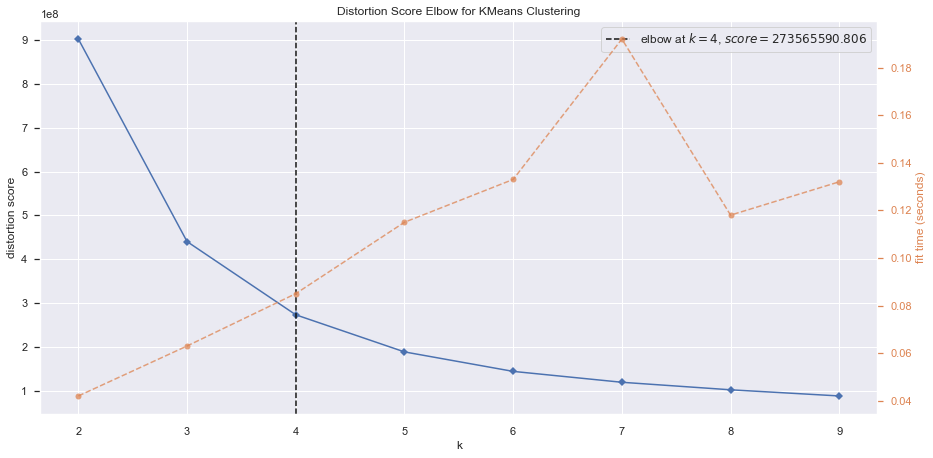

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [88]:
# Create a kmeans model
model = KMeans(random_state=42)

# Use the KElbowVisualizer to calculate distortion for different numbers of clusters
visualizer = KElbowVisualizer(model, k=(2,10), size=(1080, 520))
visualizer.fit(preprocess_df) 
visualizer.show()

The elbow method suggests that it will be ideal to divide our consumer population into four groups.

Let’s create a k-means clustering model that assigns each customer to one of four clusters.

###### Training the K-means model on the dataset

In [90]:
# Create a k-means model and assign each customer to a cluster
n_clusters = 4

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
preprocess_df['Cluster'] = kmeans.fit_predict(preprocess_df)

# KMeans predictions & Clusters
df_compare(preprocess_df.head(), pd.DataFrame(preprocess_df['Cluster'].value_counts()), titles=['Segmentation', 'Clusters'])

Segmentation 
 
 
 
 Monetary 
 Frequency 
 Recency 
 Continent 
 Cancelled 
 Cluster 
 
 
 CustomerID 
 
 
 
 
 
 
 
 
 
 
 12346.0 
 0.00 
 2 
 325 
 3 
 1 
 1 
 
 
 12347.0 
 4310.00 
 7 
 1 
 3 
 0 
 2 
 
 
 12348.0 
 1797.24 
 4 
 74 
 3 
 0 
 0 
 
 
 12349.0 
 1757.55 
 1 
 18 
 3 
 0 
 0 
 
 
 12350.0 
 334.40 
 1 
 309 
 3 
 0 
 1 
 
 
 Clusters 
 
 
 
 Cluster 
 
 
 
 
 1 
 2082 
 
 
 3 
 1035 
 
 
 0 
 511 
 
 
 2 
 223

### Silhouette Analysis
silhouette score=p−qmax(p,q)
 
p  is the mean distance to the points in the nearest cluster that the data point is not a part of

q  is the mean intra-cluster distance to all the points in its own cluster.

The value of the silhouette score range lies between -1 to 1.

A score closer to 1 indicates that the data point is very similar to other data points in the cluster,

A score closer to -1 indicates that the data point is not similar to the data points in its cluster.

In [91]:
# Calculate silhouette score
print('Accuracy score:', silhouette_score(preprocess_df, kmeans.labels_, metric='euclidean') * 100)

average_df = preprocess_df.groupby('Cluster').mean()
average_df

Accuracy score: 54.77066887660745


,Monetary,Frequency,Recency,Continent,Cancelled
Cluster,,,,,
0,1952.517241,6.088063,47.438356,2.980431,1.389432
1,287.779136,1.714697,136.556676,2.993756,0.358790
2,3400.271978,7.417040,39.206278,2.982063,1.650224
3,945.937209,3.682126,64.355556,2.995169,0.795169


## Interpretation

At this point, you may be tempted to pat yourself on the back, but the job hasn’t been done yet.<br>
Ask yourself: what have you really learned at this point?<br>
Even though you have separated your consumers into groups, does the manner of the grouping even have any meaning?<br>
If you can not explain the clusters formed by your algorithm, all your efforts are fruitless. For the people you present your findings to, a group of clusters with no well-defined traits is no different from a group of clusters made at random.
The cluster analysis will only have significance if you can explain how your customers are divided. This will allow you to understand each group and then plan a marketing strategy for each group accordingly.

We can use box plots to compare each cluster in terms of age, work experience, and family size.

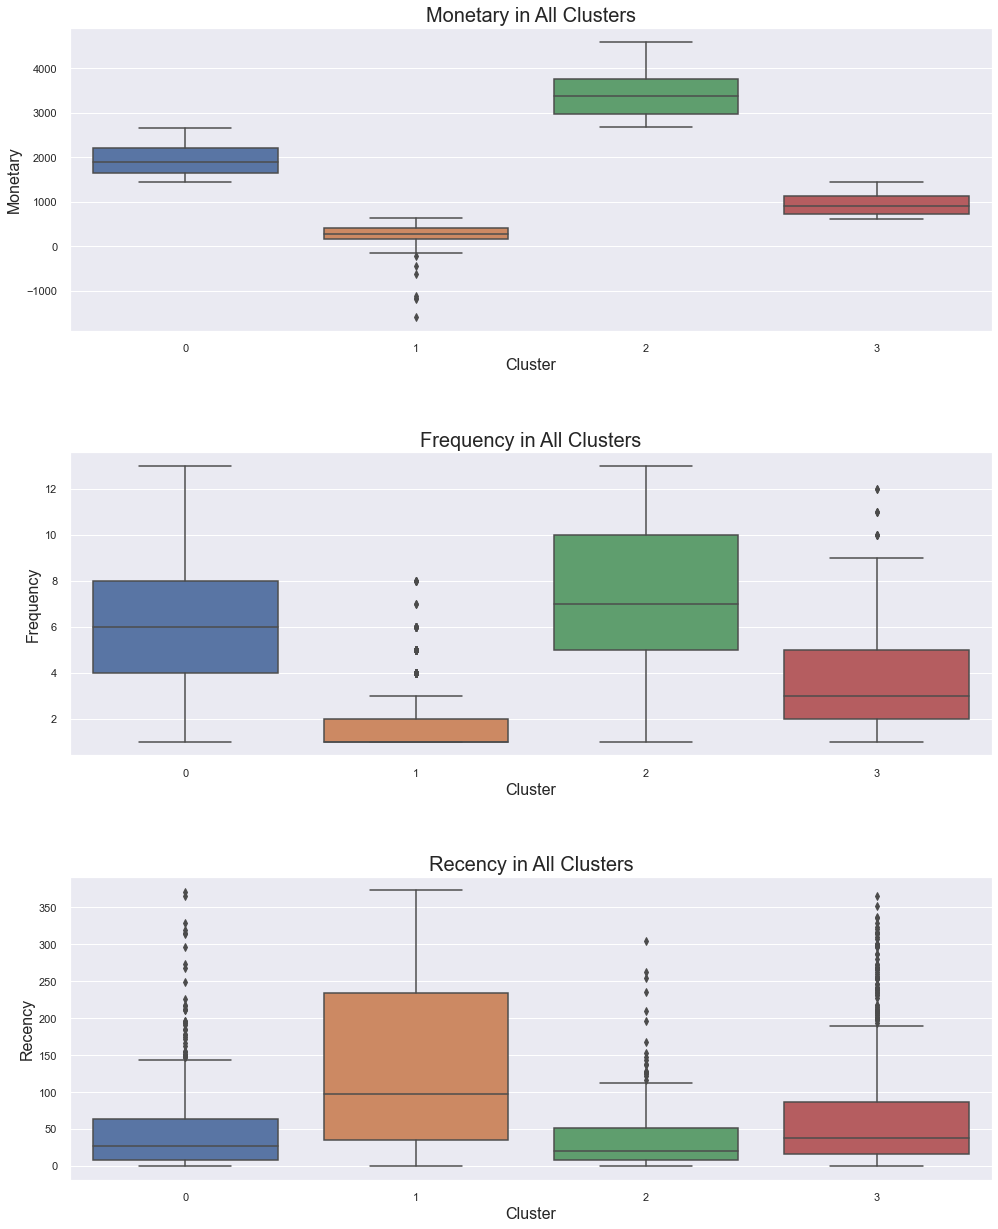

In [92]:
# Create boxplots to Amount, Products, and Recency for each cluster
fig, axes = plt.subplots(3, 1, figsize=(16, 20))
# Set the spacing between subplots
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

# Create a list containint the Amount, Products, and Recency
column_list = preprocess_df.drop(['Cluster'], axis=1).columns.tolist()

# Plot the bloxplots
for i in range(3):
    column = column_list.pop(0)
    ax = sns.boxplot(ax=axes[i], x="Cluster", y=column, data=preprocess_df)
    ax.set_title('{} in All Clusters'.format(column), fontdict={'fontsize':20})
    ax.set_xlabel('Cluster', fontdict={'fontsize':16})
    ax.set_ylabel(column, fontdict={'fontsize':16})
plt.show()

## Final Analysis
Inference:
K-Means Clustering with 3 Cluster Ids

Customers with Cluster Id 1 are the customers with high amount of transactions as compared to other customers.
Customers with Cluster Id 1 are frequent buyers.
Customers with Cluster Id 2 are not recent buyers and hence least of importance from business point of view.
Hierarchical Clustering with 3 Cluster Labels

Customers with Cluster_Labels 2 are the customers with high amount of transactions as compared to other customers.
Customers with Cluster_Labels 2 are frequent buyers.
Customers with Cluster_Labels 0 are not recent buyers and hence least of importance from business point of view.